In [1]:
import pandas  as pd
import tensorflow as tf
import numpy as np
import seaborn as sn
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

In [2]:
import dotenv
import pydot
import requests
import numpy as np
import pandas as pd
import ctypes
import shutil
import multiprocessing
import multiprocessing.sharedctypes as sharedctypes
import os.path
import ast


# Number of samples per 30s audio clip.
# TODO: fix dataset to be constant.
NB_AUDIO_SAMPLES = 1321967
SAMPLING_RATE = 44100

# Load the environment from the .env file.
dotenv.load_dotenv(dotenv.find_dotenv())


class FreeMusicArchive:

    BASE_URL = 'https://freemusicarchive.org/api/get/'

    def __init__(self, api_key):
        self.api_key = api_key

    def get_recent_tracks(self):
        URL = 'https://freemusicarchive.org/recent.json'
        r = requests.get(URL)
        r.raise_for_status()
        tracks = []
        artists = []
        date_created = []
        for track in r.json()['aTracks']:
            tracks.append(track['track_id'])
            artists.append(track['artist_name'])
            date_created.append(track['track_date_created'])
        return tracks, artists, date_created

    def _get_data(self, dataset, fma_id, fields=None):
        url = self.BASE_URL + dataset + 's.json?'
        url += dataset + '_id=' + str(fma_id) + '&api_key=' + self.api_key
        # print(url)
        r = requests.get(url)
        r.raise_for_status()
        if r.json()['errors']:
            raise Exception(r.json()['errors'])
        data = r.json()['dataset'][0]
        r_id = data[dataset + '_id']
        if r_id != str(fma_id):
            raise Exception('The received id {} does not correspond to'
                            'the requested one {}'.format(r_id, fma_id))
        if fields is None:
            return data
        if type(fields) is list:
            ret = {}
            for field in fields:
                ret[field] = data[field]
            return ret
        else:
            return data[fields]

    def get_track(self, track_id, fields=None):
        return self._get_data('track', track_id, fields)

    def get_album(self, album_id, fields=None):
        return self._get_data('album', album_id, fields)

    def get_artist(self, artist_id, fields=None):
        return self._get_data('artist', artist_id, fields)

    def get_all(self, dataset, id_range):
        index = dataset + '_id'

        id_ = 2 if dataset == 'track' else 1
        row = self._get_data(dataset, id_)
        df = pd.DataFrame(columns=row.keys())
        df.set_index(index, inplace=True)

        not_found_ids = []

        for id_ in id_range:
            try:
                row = self._get_data(dataset, id_)
            except:
                not_found_ids.append(id_)
                continue
            row.pop(index)
            df = df.append(pd.Series(row, name=id_))

        return df, not_found_ids

    def download_track(self, track_file, path):
        url = 'https://files.freemusicarchive.org/' + track_file
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    def get_track_genres(self, track_id):
        genres = self.get_track(track_id, 'track_genres')
        genre_ids = []
        genre_titles = []
        for genre in genres:
            genre_ids.append(genre['genre_id'])
            genre_titles.append(genre['genre_title'])
        return genre_ids, genre_titles

    def get_all_genres(self):
        df = pd.DataFrame(columns=['genre_parent_id', 'genre_title',
                                   'genre_handle', 'genre_color'])
        df.index.rename('genre_id', inplace=True)

        page = 1
        while True:
            url = self.BASE_URL + 'genres.json?limit=50'
            url += '&page={}&api_key={}'.format(page, self.api_key)
            r = requests.get(url)
            for genre in r.json()['dataset']:
                genre_id = int(genre.pop(df.index.name))
                df.loc[genre_id] = genre
            assert (r.json()['page'] == str(page))
            page += 1
            if page > r.json()['total_pages']:
                break

        return df


class Genres:

    def __init__(self, genres_df):
        self.df = genres_df

    def create_tree(self, roots, depth=None):

        if type(roots) is not list:
            roots = [roots]
        graph = pydot.Dot(graph_type='digraph', strict=True)

        def create_node(genre_id):
            title = self.df.at[genre_id, 'title']
            ntracks = self.df.at[genre_id, '#tracks']
            # name = self.df.at[genre_id, 'title'] + '\n' + str(genre_id)
            name = '"{}\n{} / {}"'.format(title, genre_id, ntracks)
            return pydot.Node(name)

        def create_tree(root_id, node_p, depth):
            if depth == 0:
                return
            children = self.df[self.df['parent'] == root_id]
            for child in children.iterrows():
                genre_id = child[0]
                node_c = create_node(genre_id)
                graph.add_edge(pydot.Edge(node_p, node_c))
                create_tree(genre_id, node_c,
                            depth-1 if depth is not None else None)

        for root in roots:
            node_p = create_node(root)
            graph.add_node(node_p)
            create_tree(root, node_p, depth)

        return graph

    def find_roots(self):
        roots = []
        for gid, row in self.df.iterrows():
            parent = row['parent']
            title = row['title']
            if parent == 0:
                roots.append(gid)
            elif parent not in self.df.index:
                msg = '{} ({}) has parent {} which is missing'.format(
                        gid, title, parent)
                raise RuntimeError(msg)
        return roots


def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small','medium','large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))
            #tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    #'category', categories=SUBSETS, ordered=True)
        except ValueError:
             #the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'

    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


class Loader:
    def load(self, filepath):
        raise NotImplementedError()


class RawAudioLoader(Loader):
    def __init__(self, sampling_rate=SAMPLING_RATE):
        self.sampling_rate = sampling_rate
        self.shape = (NB_AUDIO_SAMPLES * sampling_rate // SAMPLING_RATE, )

    def load(self, filepath):
        return self._load(filepath)[:self.shape[0]]


class LibrosaLoader(RawAudioLoader):
    def _load(self, filepath):
        import librosa
        sr = self.sampling_rate if self.sampling_rate != SAMPLING_RATE else None
        # kaiser_fast is 3x faster than kaiser_best
        # x, sr = librosa.load(filepath, sr=sr, res_type='kaiser_fast')
        x, sr = librosa.load(filepath, sr=sr)
        return x


class AudioreadLoader(RawAudioLoader):
    def _load(self, filepath):
        import audioread
        a = audioread.audio_open(filepath)
        a.read_data()


class PydubLoader(RawAudioLoader):
    def _load(self, filepath):
        from pydub import AudioSegment
        song = AudioSegment.from_file(filepath)
        song = song.set_channels(1)
        x = song.get_array_of_samples()
        # print(filepath) if song.channels != 2 else None
        return np.array(x)


class FfmpegLoader(RawAudioLoader):
    def _load(self, filepath):
        """Fastest and less CPU intensive loading method."""
        import subprocess as sp
        command = ['ffmpeg',
                   '-i', filepath,
                   '-f', 's16le',
                   '-acodec', 'pcm_s16le',
                   '-ac', '1']  # channels: 2 for stereo, 1 for mono
        if self.sampling_rate != SAMPLING_RATE:
            command.extend(['-ar', str(self.sampling_rate)])
        command.append('-')
        # 30s at 44.1 kHz ~= 1.3e6
        proc = sp.run(command, stdout=sp.PIPE, bufsize=10**7, stderr=sp.DEVNULL, check=True)

        return np.fromstring(proc.stdout, dtype="int16")


def build_sample_loader(audio_dir, Y, loader):

    class SampleLoader:

        def __init__(self, tids, batch_size=4):
            self.lock1 = multiprocessing.Lock()
            self.lock2 = multiprocessing.Lock()
            self.batch_foremost = sharedctypes.RawValue(ctypes.c_int, 0)
            self.batch_rearmost = sharedctypes.RawValue(ctypes.c_int, -1)
            self.condition = multiprocessing.Condition(lock=self.lock2)

            data = sharedctypes.RawArray(ctypes.c_int, tids.data)
            self.tids = np.ctypeslib.as_array(data)

            self.batch_size = batch_size
            self.loader = loader
            self.X = np.empty((self.batch_size, *loader.shape))
            self.Y = np.empty((self.batch_size, Y.shape[1]), dtype=np.int)

        def __iter__(self):
            return self

        def __next__(self):

            with self.lock1:
                if self.batch_foremost.value == 0:
                    np.random.shuffle(self.tids)

                batch_current = self.batch_foremost.value
                if self.batch_foremost.value + self.batch_size < self.tids.size:
                    batch_size = self.batch_size
                    self.batch_foremost.value += self.batch_size
                else:
                    batch_size = self.tids.size - self.batch_foremost.value
                    self.batch_foremost.value = 0

                # print(self.tids, self.batch_foremost.value, batch_current, self.tids[batch_current], batch_size)
                # print('queue', self.tids[batch_current], batch_size)
                tids = np.array(self.tids[batch_current:batch_current+batch_size])

            batch_size = 0
            for tid in tids:
                try:
                    audio_path = get_audio_path(audio_dir, tid)
                    self.X[batch_size] = self.loader.load(audio_path)
                    self.Y[batch_size] = Y.loc[tid]
                    batch_size += 1
                except Exception as e:
                    print("\nIgnoring " + audio_path +" (error: " + str(e) +").")

            with self.lock2:
                while (batch_current - self.batch_rearmost.value) % self.tids.size > self.batch_size:
                    # print('wait', indices[0], batch_current, self.batch_rearmost.value)
                    self.condition.wait()
                self.condition.notify_all()
                # print('yield', indices[0], batch_current, self.batch_rearmost.value)
                self.batch_rearmost.value = batch_current

                return self.X[:batch_size], self.Y[:batch_size]

    return SampleLoader


In [3]:
AUDIO_DIR = os.environ.get('fma_medium')

tracks = load('/home/akshat/Downloads/fma_metadata/tracks.csv')
genres = load('/home/akshat/Downloads/fma_metadata/genres.csv')
features = load('/home/akshat/Downloads/fma_metadata/features.csv')
echonest = load('/home/akshat/Downloads/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())



,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [5]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=True)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
13,730,0,Easy Listening,13
8,868,0,Old-Time / Historic,8
14,1499,0,Soul-RnB,14
3,1752,0,Blues,3
20,1876,0,Spoken,20
9,1987,0,Country,9
5,4106,0,Classical,5
4,4126,0,Jazz,4
2,5271,0,International,2


In [6]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


In [7]:
pip install pysoundfile

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
#filename = get_audio_path(fma_large, 2)
filename = '/home/akshat/Downloads/fma_medium/000/000005.mp3'
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)



File: /home/akshat/Downloads/fma_medium/000/000005.mp3


/home/akshat/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323119 samples


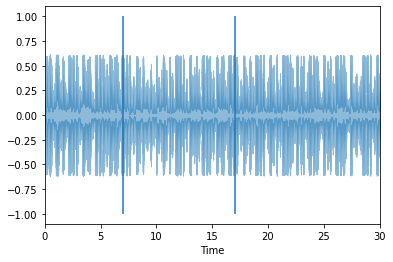

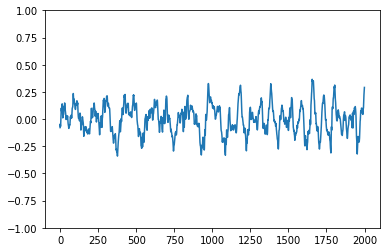

In [8]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));



/home/akshat/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/akshat/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


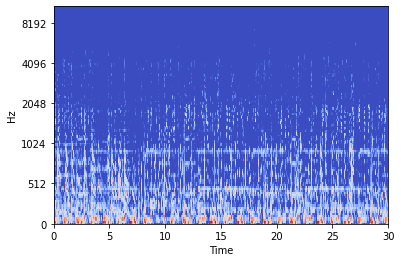

In [9]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

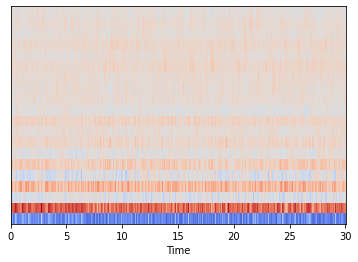

In [10]:


mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');



In [11]:
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

In [14]:
y_train.head()

track_id
2     Hip-Hop
3     Hip-Hop
5     Hip-Hop
10        Pop
20        NaN
Name: (track, genre_top), dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [13]:
y_train = tracks.loc[train, ('track', 'genre_top')]
y_test = tracks.loc[ test, ('track', 'genre_top')]
X_train = features.loc[train, 'mfcc']
X_test = features.loc[test, 'mfcc']

In [16]:
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
#print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

84353 training examples, 11263 testing examples


In [17]:
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.12802746, -0.12391912,  0.03646343, ...,  0.10555911,
        -0.0652309 ,  0.34629423],
       [ 1.47454336,  0.52389687,  1.35996027, ..., -0.3851356 ,
        -0.62119444, -0.58377058],
       [ 1.81635372,  7.50270124, -0.18677967, ..., -0.70339269,
        -0.6952931 , -0.24572858],
       ...,
       [ 0.72198024,  2.58506405, -0.15548551, ..., -0.91600602,
        -0.98200071, -0.78871263],
       [-0.26466963, -0.70744963, -0.23680487, ..., -0.42463824,
        -0.44046806, -0.27915024],
       [-0.12697367, -0.55882075, -0.20774626, ...,  2.01778545,
         1.46939142,  1.28218262]])

In [18]:
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

ValueError: Input contains NaN